In [1]:
import sys
sys.executable

'/usr/bin/python3.6'

In [3]:
import argparse
import keras.backend as K
from keras.callbacks import Callback
from keras.layers import Input, Lambda, LeakyReLU, Conv2D, TimeDistributed, \
    Dense, Flatten
from keras.models import Model
from keras.optimizers import Adam
from keras.regularizers import L1L2
import librosa
import numpy as np
import random

from utils import list_sounds, open_sound


def mk_model():
    input_lower = Input((None, 257), name="input_lf")
    layer = Lambda(K.expand_dims)(input_lower)
    layer = LeakyReLU(0.01)(Conv2D(12, kernel_size=(9, 1), padding='same', activation='linear')(layer))
    layer = LeakyReLU(0.01)(Conv2D(12, kernel_size=(1, 5), padding='same', activation='linear')(layer))
    layer = LeakyReLU(0.01)(Conv2D(12, kernel_size=(9, 1), padding='same', activation='linear')(layer))
    layer = LeakyReLU(0.01)(Conv2D(12, kernel_size=(1, 5), padding='same', activation='linear')(layer))
    layer = TimeDistributed(Flatten())(layer)
    layer = LeakyReLU(0.01)(Dense(1024, kernel_regularizer=L1L2(l1=1e-5))(layer))
    layer = LeakyReLU(0.01, name='hidden')(Dense(512, kernel_regularizer=L1L2(l1=1e-5))(layer))
    layer = LeakyReLU(0.01)(Dense(350, kernel_regularizer=L1L2(l2=1e-5))(layer))
    layer = Dense(257)(layer)
    mdl = Model(input_lower, layer)
    mdl.summary()
    return mdl


class StopOnConvergence(Callback):
    def __init__(self, max_repetitions=10):
        super().__init__()
        self.max_repetitions = max_repetitions

    def on_train_begin(self, logs=None):
        self.repetitions = 0
        self.last_loss = np.inf

    def on_epoch_end(self, batch, logs=None):
        logs = logs or {}
        loss = logs.get('val_loss')
        if loss is not None:
            if loss > self.last_loss:
                self.repetitions += 1
            else:
                self.last_loss = loss
                self.repetitions = 0
            if self.repetitions > self.max_repetitions:
                self.model.stop_training = True


class Simulator:
    def __init__(self):
        self.n_records = 3000
        self.valid = 200
        self.test = 200
        self.train = self.n_records - self.valid - self.test
        self.fnames = []

    def load(self, path):
        fnames = list_sounds(path)
        self.fnames = fnames = random.sample(fnames, self.n_records)
        max_len = max([len(open_sound(x)[1]) for x in fnames])
        max_len = 1 + (max_len - 512) // 128
        self.X = np.ones([self.n_records, max_len, 257], np.float32)
        self.Y = np.ones([self.n_records, max_len, 257], np.float32)
        self.X *= np.log(2e-12)
        self.Y *= np.log(2e-12)
        for ix, fname in enumerate(fnames):
            sr, rec = open_sound(fname)
            assert sr == 16000
            rec = np.log(2e-12 + np.abs(librosa.stft(rec.astype(np.float32) / (2**15), n_fft=512, hop_length=128).T[:max_len]) ** 2)
            self.X[ix, :len(rec)] = self.mask(rec)
            self.Y[ix, :len(rec)] = rec
        return ([self.X[:self.train], self.Y[:self.train]],
                [self.X[self.train:self.train+self.valid], self.Y[self.train:self.train+self.valid]],
                [self.X[-self.test:], self.Y[-self.test:]])

    def mask(self, spec):
        sigmoid = lambda x: 1 / (1 + np.exp(-x))
        random_values = np.random.random(spec.shape)
        random_values = 2.5 * spec.mean() * np.random.random(spec.shape)
        mask = random_values > spec
        return mask * (spec.std() * sigmoid(random_values) + spec.mean()) + (1 - mask) * spec



def save_model(model, path):
    """
    Model should be stripped of all callbacks and needless objects...
    """
    model.save(path)


def training(dataset, path):
    [train_X, train_Y], [valid_X, valid_Y], [test_X, test_Y] = dataset
    model = mk_model()
    # backup_callback = BackupCallback()
    for lr in [0.0003, 0.0001, 0.00003]:
        model.compile(optimizer=Adam(lr, clipnorm=1.), loss='mse')
        model.fit(train_X, train_Y, validation_data=[valid_X, valid_Y], epochs=50,
                    callbacks=[StopOnConvergence(5)], batch_size=8)  # , backup_callback])
    # test...
    save_model(model, path)  # create postfilter object...


imports = {"StopOnConvergence": StopOnConvergence}


def main(folder_path, output_path):
    loader = Simulator()
    dataset = loader.load(folder_path)
    training(dataset, path=output_path)


In [3]:
main("DAE-libri-cp", "dae-model.h5")

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_lf (InputLayer)        (None, None, 257)         0         
_________________________________________________________________
lambda_1 (Lambda)            (None, None, 257, 1)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, None, 257, 16)     160       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, None, 257, 16)     0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, None, 257, 20)     1620      
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, None, 257, 20)     0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, None, 257, 24)     4344      
__________

Epoch 2/50
2600/2600 [==============================] - 169s 65ms/step - loss: 0.3344 - val_loss: 0.3333
Epoch 3/50
2600/2600 [==============================] - 169s 65ms/step - loss: 0.3471 - val_loss: 0.3377
Epoch 4/50
2600/2600 [==============================] - 169s 65ms/step - loss: 0.3225 - val_loss: 0.2947
Epoch 5/50
2600/2600 [==============================] - 169s 65ms/step - loss: 0.3219 - val_loss: 0.3309
Epoch 6/50
2600/2600 [==============================] - 169s 65ms/step - loss: 0.3449 - val_loss: 0.3014
Epoch 7/50
2600/2600 [==============================] - 169s 65ms/step - loss: 0.3355 - val_loss: 0.3140
Epoch 8/50
2600/2600 [==============================] - 169s 65ms/step - loss: 0.3386 - val_loss: 0.3064
Epoch 9/50
2600/2600 [==============================] - 169s 65ms/step - loss: 0.3367 - val_loss: 0.3420
Epoch 10/50
2600/2600 [==============================] - 169s 65ms/step - loss: 0.3365 - val_loss: 0.3241
Train on 2600 samples, validate on 200 samples
Epoch 1

In [1]:
import keras
import tensorflow as tf

dae = keras.models.load_model("dae-model.h5", {"tf": tf})

Using TensorFlow backend.


Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.


In [4]:
loader = dataset = None
loader = Simulator()
dataset = loader.load("DAE-libri-cp")

In [11]:
import scipy.io.wavfile as sio
phaze = loader.fnames[2800]
phaze = np.angle(librosa.stft(sio.read(phaze)[1].astype(np.float32) / 2**15, n_fft=512, hop_length=128).T)

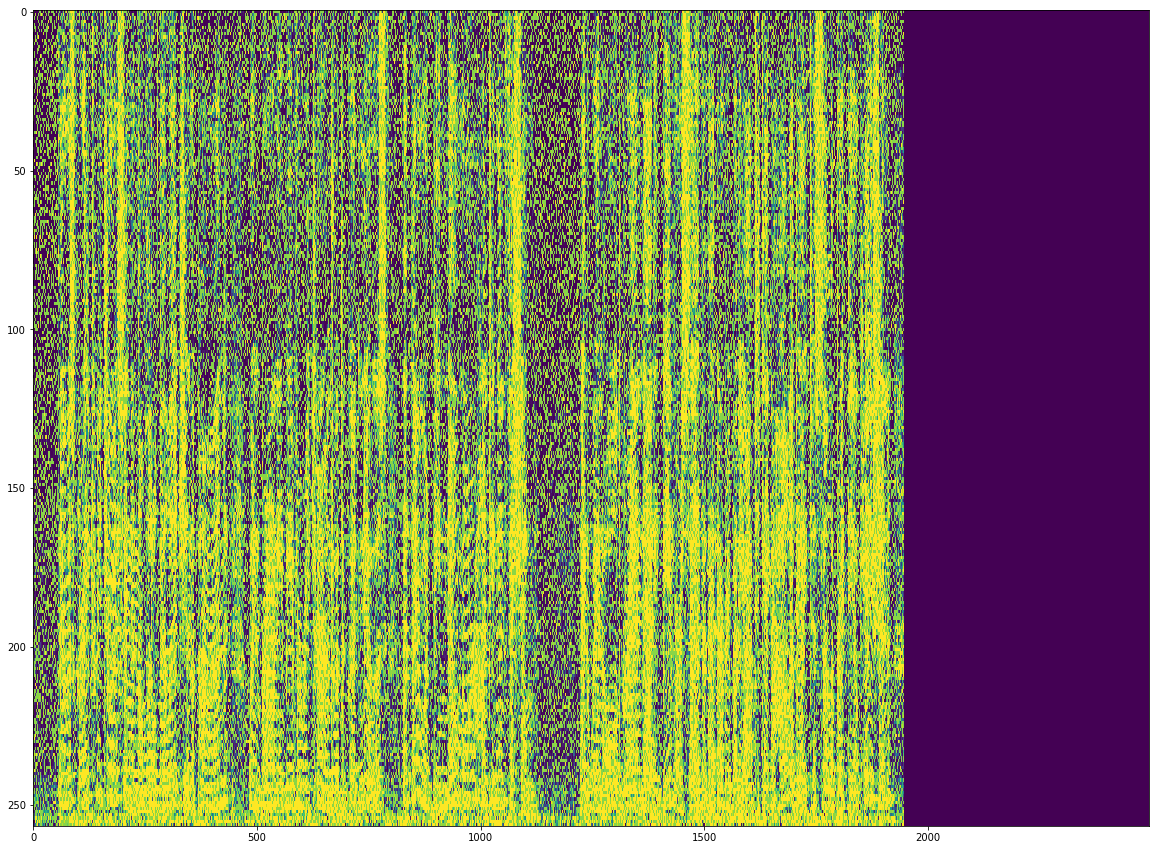

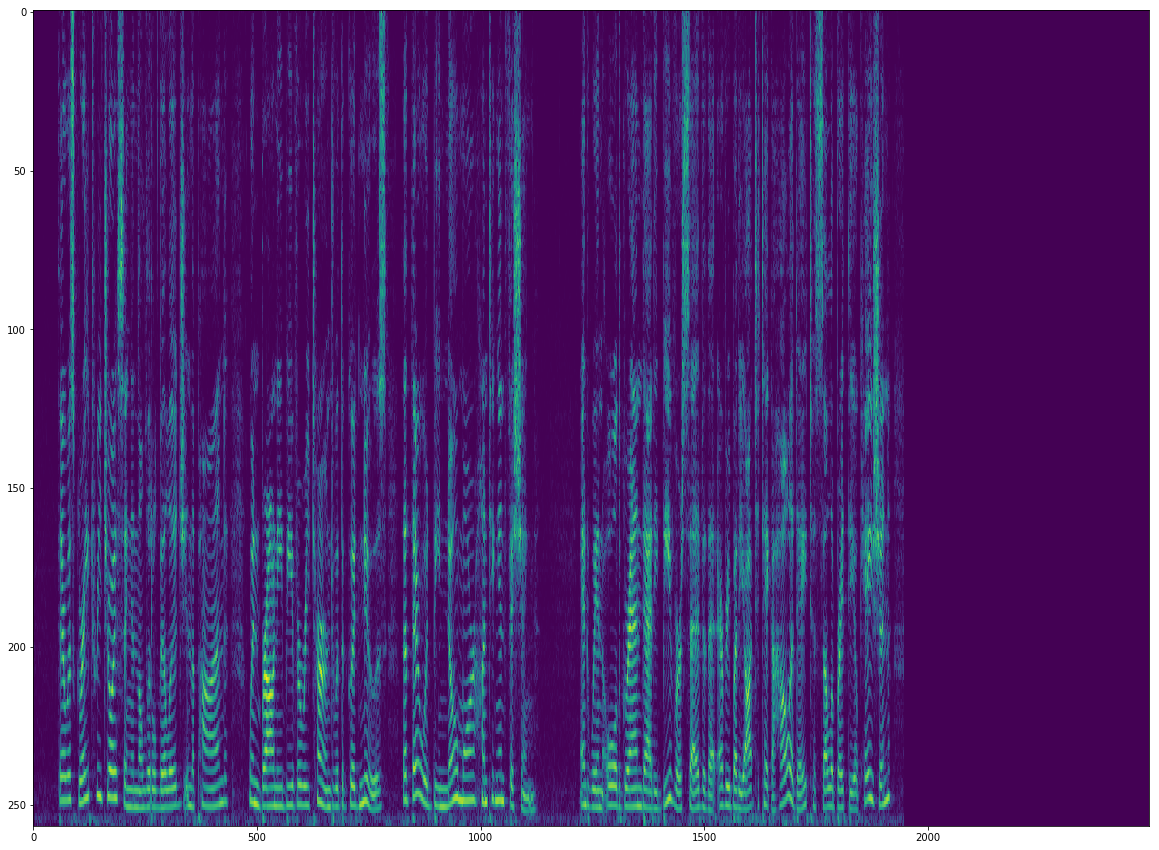

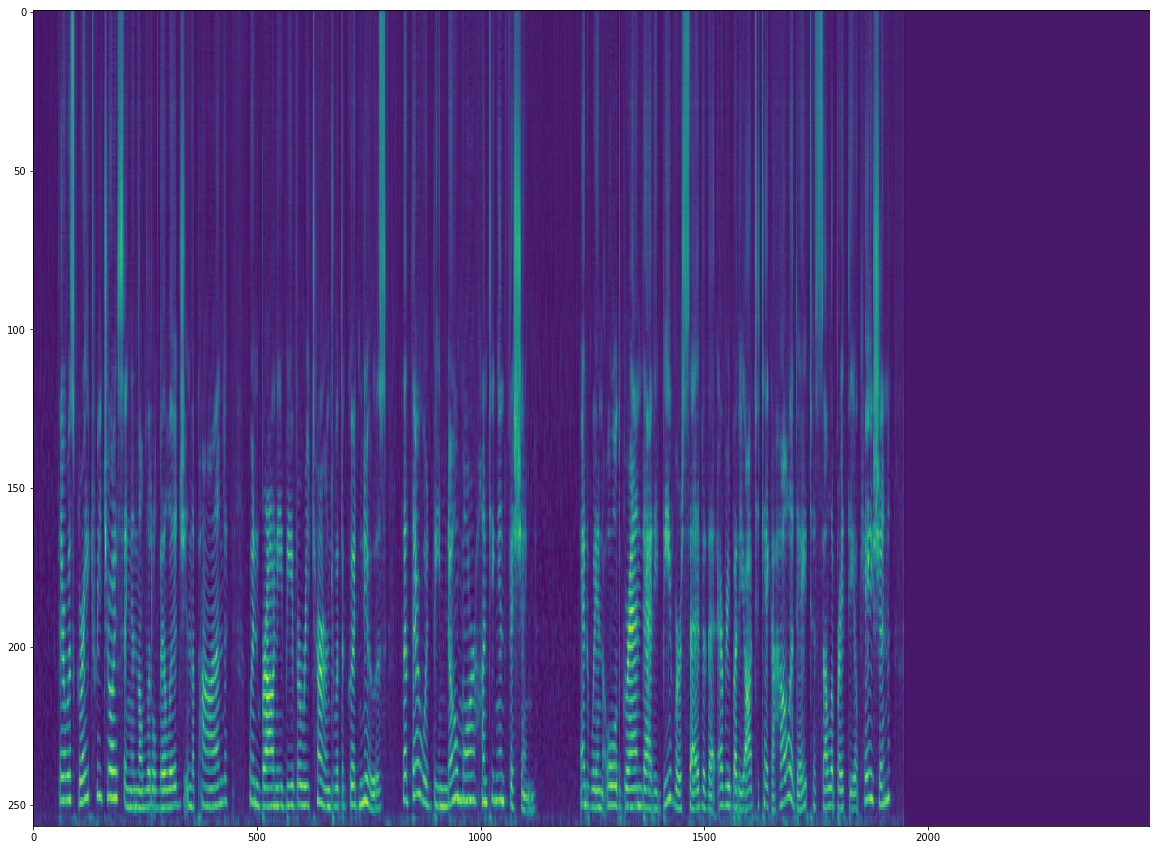

In [18]:
import matplotlib.pyplot as plt
noisy_img = dataset[2][0][0]
clean_img = dataset[2][1][0]

plt.figure(figsize=(20, 15))
plt.imshow(np.flip(noisy_img.T, 0), aspect='auto', vmax=-25)
plt.show()
plt.figure(figsize=(20, 15))
plt.imshow(np.flip(clean_img.T, 0), aspect='auto')
plt.show()

denoised = dae.predict(noisy_img.reshape(1, -1, 257))
plt.figure(figsize=(20, 15))
plt.imshow(np.flip(denoised[0].T, 0), aspect='auto')
plt.show()


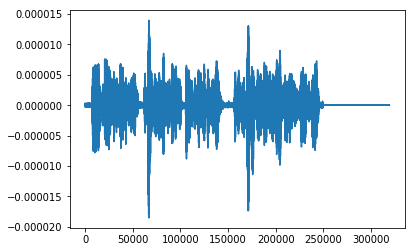

In [16]:
Denoised = np.sqrt(np.exp(denoised[0]))
Denoised = Denoised * np.exp(1j * np.pad(phaze, ((0, 2495 - 1948), (0, 0)), 'constant'))
Denoised = librosa.istft(Denoised.T, window = np.hamming)
plt.plot(Denoised)
from IPython.display import display, Audio
display(Audio(Denoised, rate=16000))

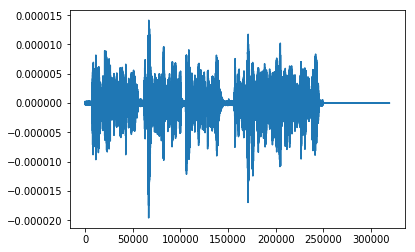

In [17]:
Denoised = np.sqrt(np.exp(clean_img))
Denoised = Denoised * np.exp(1j * np.pad(phaze, ((0, 2495 - 1948), (0, 0)), 'constant'))
Denoised = librosa.istft(Denoised.T, window=np.hamming)
plt.plot(Denoised)
from IPython.display import display, Audio
display(Audio(Denoised, rate=16000))

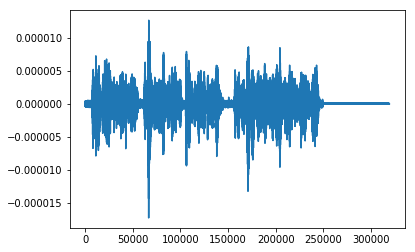

In [19]:
Denoised = np.sqrt(np.exp(noisy_img))
Denoised = Denoised * np.exp(1j * np.pad(phaze, ((0, 2495 - 1948), (0, 0)), 'constant'))
Denoised = librosa.istft(Denoised.T, window=np.hamming)
plt.plot(Denoised)
from IPython.display import display, Audio
display(Audio(Denoised, rate=16000))

In [12]:
import librosa
import numpy as np
import os
import scipy.io.wavfile as sio

cleans = os.listdir("../dockerdrive/DASHclean/")
noisy = os.listdir("../dockerdrive/DASHnoisy")
cleans = [sio.read("../dockerdrive/DASHclean/" + x)[1].astype(np.float32) / 2**15 for x in cleans]
noisy = [sio.read("../dockerdrive/DASHnoisy/" + x)[1].astype(np.float32) / 2**15 for x in noisy]
cleans = [librosa.stft(x, n_fft=512, hop_length=128).T for x in cleans for i in range(6)]
noisy = [librosa.stft(x, n_fft=512, hop_length=128).T for record in noisy for x in record.T]

In [13]:
clean = cleans[43]
noise = np.abs(noisy[43])
denoised = dae.predict(np.log(noise**2 + 2e-12).reshape(1, -1, 257))

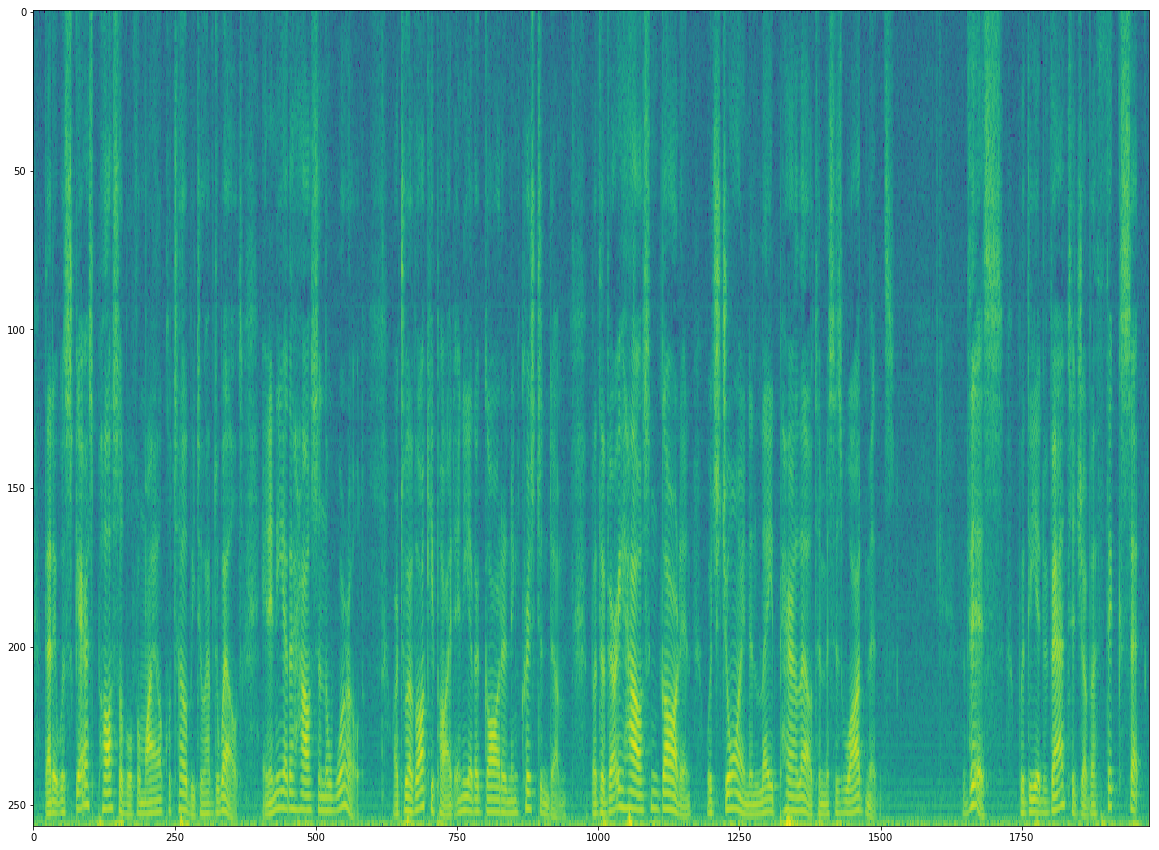

In [14]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20, 15))
plt.imshow(np.flip(np.log(np.abs(clean)**2).T, 0), aspect='auto')


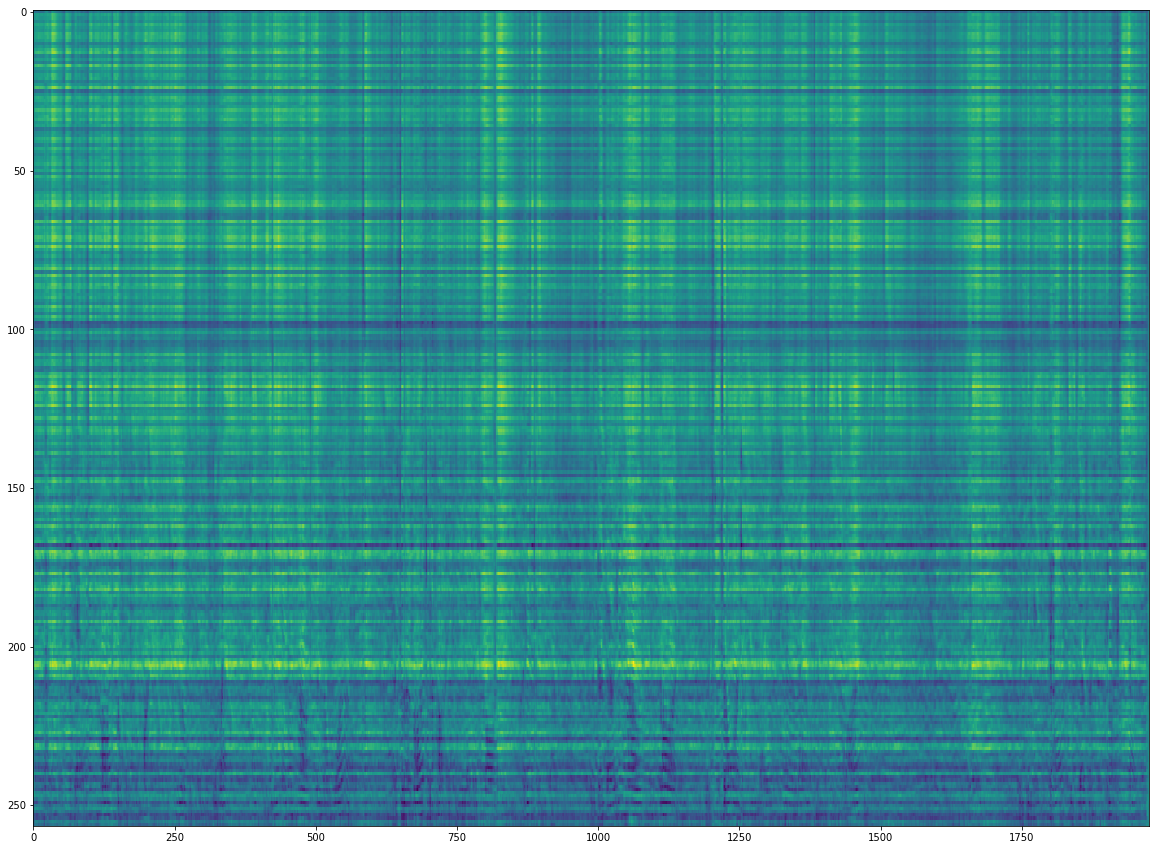

In [15]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20, 15))
plt.imshow(np.flip(denoised[0].T, 0), aspect='auto')


/usr/lib/python3.6/site-packages/librosa/util/utils.py:1725: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if np.issubdtype(x.dtype, float) or np.issubdtype(x.dtype, complex):


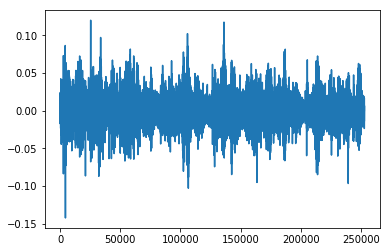

In [16]:
Denoised = np.sqrt(np.exp(denoised))
Denoised = Denoised * np.exp(1j * np.angle(clean))
Denoised = Denoised[0]
Denoised = librosa.istft(Denoised.T)
plt.plot(Denoised)


In [17]:
from IPython.display import display, Audio
display(Audio(Denoised, rate=16000))